In [1]:
%pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/124.9 MB 2.4 MB/s eta 0:00:52
   ---------------------------------------- 1.3/124.9 MB 2.5 MB/s eta 0:00:50
    --------------------------------------- 2.1/124.9 MB 2.9 MB/s eta 0:00:42
    --------------------------------------- 2.9/124.9 MB 3.2 MB/s eta 0:00:38
   - -------------------------------------- 3.4/124.9 MB 3.1 MB/s eta 0:00:39
   - -------------------------------------- 3.4/124.9 MB 3.1 MB/s eta 0:00:39
   - -------------------------------------- 4.2/124.9 MB 2.7 MB/s eta 0:00:45
   - -------------------------------------- 5.0/124.9 MB 2.7 MB/s eta 0:00:44
   - -------------------------------------- 5.8/124.9 MB 2.9 MB/s eta 0:00:42
   -- ------------------------------------- 6.8/124.9 MB 3.0 MB/s eta 0:00:39
   -- ------------------------------------- 7.6/124.9 MB 3.1 MB/s eta 0:00:38

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import joblib

# Load the dataset
df = pd.read_excel(r"C:\Users\rsmvs\OneDrive\Desktop\Climate Project\tree cover loss.xlsx")

print(df.columns)

Index(['country', 'subnational1', 'threshold', 'area_ha', 'extent_2000_ha',
       'extent_2010_ha', 'gain_2000-2020_ha', 'tc_loss_ha_2001',
       'tc_loss_ha_2002', 'tc_loss_ha_2003', 'tc_loss_ha_2004',
       'tc_loss_ha_2005', 'tc_loss_ha_2006', 'tc_loss_ha_2007',
       'tc_loss_ha_2008', 'tc_loss_ha_2009', 'tc_loss_ha_2010',
       'tc_loss_ha_2011', 'tc_loss_ha_2012', 'tc_loss_ha_2013',
       'tc_loss_ha_2014', 'tc_loss_ha_2015', 'tc_loss_ha_2016',
       'tc_loss_ha_2017', 'tc_loss_ha_2018', 'tc_loss_ha_2019',
       'tc_loss_ha_2020', 'tc_loss_ha_2021', 'tc_loss_ha_2022',
       'tc_loss_ha_2023', 'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

# === 1. Load your data ===
df = pd.read_excel(r"C:\Users\rsmvs\OneDrive\Desktop\Climate Project\tree cover loss.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# === 2. Convert key features to numeric ===
key_cols = ['area_ha', 'extent_2000_ha', 'extent_2010_ha', 'gain_2000-2020_ha']
for col in key_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Find the only tree loss column (if any)
tree_loss_cols = [col for col in df.columns if col.startswith("tc_loss_ha_")]
if len(tree_loss_cols) == 0:
    raise ValueError("No tree loss column found like 'tc_loss_ha_YYYY'.")

tree_col = tree_loss_cols[0]  # Use the only available tree loss column
df[tree_col] = pd.to_numeric(df[tree_col], errors='coerce')

# === 3. Clean & define target label ===
df = df.dropna(subset=key_cols + [tree_col])
df['loss_label'] = np.where(df[tree_col] > df[tree_col].median(), "HighLoss", "LowLoss")

# Encode label
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["loss_label"])

# === 4. Train model ===
features = key_cols
X = df[features]
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === 5. Evaluate ===
y_pred = model.predict(X_test)
print("✅ Evaluation on single-year tree loss prediction:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === 6. Save model ===
joblib.dump(model, "tree_loss_binary_model.pkl")
print("✅ Model saved as 'tree_loss_binary_model.pkl'")


✅ Evaluation on single-year tree loss prediction:

              precision    recall  f1-score   support

    HighLoss       0.97      0.91      0.94        32
     LowLoss       0.89      0.96      0.93        26

    accuracy                           0.93        58
   macro avg       0.93      0.93      0.93        58
weighted avg       0.93      0.93      0.93        58

✅ Model saved as 'tree_loss_binary_model.pkl'


In [20]:
import pandas as pd
import numpy as np

# === Step 1: Load your dataset ===
df = pd.read_excel(r"C:\Users\rsmvs\OneDrive\Desktop\Climate Project\tree cover loss.xlsx")

# === Step 2: Clean it ===
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.fillna(0)

# === Step 3: Identify the tree loss columns dynamically ===
yearly_cols = [col for col in df.columns if col.startswith("tc_loss_ha_")]

# Confirm we have enough years
if len(yearly_cols) < 2:
    raise ValueError("Not enough tree loss columns to analyze trends.")

# === Step 4: Calculate average loss in 2 halves ===
mid = len(yearly_cols) // 2
earlier_cols = yearly_cols[:mid]
recent_cols = yearly_cols[mid:]

df["avg_earlier"] = df[earlier_cols].mean(axis=1)
df["avg_recent"] = df[recent_cols].mean(axis=1)

# === Step 5: Label each state ===
df["Climate_Health"] = np.where(df["avg_recent"] > df["avg_earlier"], "Degrading", "Improving")

# === Step 6: Show result ===
print("🌍 Climate Health Prediction per State:\n")
print(df[["subnational1", "Climate_Health"]])

# Save the predictions to a CSV file
df[["subnational1", "Climate_Health"]].to_csv("climate_health_predictions.csv", index=False)
print("✅ File saved as 'climate_health_predictions.csv'")


🌍 Climate Health Prediction per State:

            subnational1 Climate_Health
0    Andaman and Nicobar      Improving
1    Andaman and Nicobar      Improving
2    Andaman and Nicobar      Improving
3    Andaman and Nicobar      Improving
4    Andaman and Nicobar      Improving
..                   ...            ...
283          West Bengal      Improving
284          West Bengal      Improving
285          West Bengal      Improving
286          West Bengal      Improving
287          West Bengal      Improving

[288 rows x 2 columns]
✅ File saved as 'climate_health_predictions.csv'


In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib

# === 1. Load the dataset ===
df = pd.read_excel(r"C:\Users\rsmvs\OneDrive\Desktop\Climate Project\carbon data.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.fillna(0)

# === 2. Identify carbon emission columns ===
emission_cols = [col for col in df.columns if "gfw_forest_carbon_gross_emissions_" in col and col.endswith("__Mg_CO2e")]

# Convert emissions columns to numeric
for col in emission_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df["invalid_count"] = df[emission_cols].isna().sum(axis=1)
df = df[df["invalid_count"] < len(emission_cols) * 0.5]
df.drop(columns=["invalid_count"], inplace=True)
df[emission_cols] = df[emission_cols].fillna(0)

# === 3. Create label: Carbon_Health ===
mid = len(emission_cols) // 2
earlier = emission_cols[:mid]
recent = emission_cols[mid:]

df["avg_earlier_emissions"] = df[earlier].mean(axis=1)
df["avg_recent_emissions"] = df[recent].mean(axis=1)

df["Carbon_Health"] = np.where(
    df["avg_recent_emissions"] > df["avg_earlier_emissions"],
    "Degrading", "Improving"
)

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["Carbon_Health"])

# === 4. Train the model ===
X = df[emission_cols]
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === 5. Evaluate ===
y_pred = model.predict(X_test)
print("✅ Carbon Health Model Evaluation:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === 6. Save the model ===
joblib.dump(model, "carbon_health_model.joblib")
print("✅ Model saved as 'carbon_health_model.joblib'")


✅ Carbon Health Model Evaluation:

              precision    recall  f1-score   support

   Degrading       1.00      0.73      0.84        11
   Improving       0.94      1.00      0.97        47

    accuracy                           0.95        58
   macro avg       0.97      0.86      0.91        58
weighted avg       0.95      0.95      0.94        58

✅ Model saved as 'carbon_health_model.joblib'


In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv(r"C:\Users\rsmvs\OneDrive\Desktop\Climate Project\Combined_Climate___Carbon_Health.csv")

# Create target label
df["Forest_Health_Status"] = df.apply(
    lambda row: "Healthy" if row["Carbon_Health_Status"] == "Improving" and row["Tree_Cover_Health_Status"] == "Improving"
    else "At Risk", axis=1
)

# Encode features
le_carbon = LabelEncoder()
le_tree = LabelEncoder()
le_target = LabelEncoder()

df["carbon_encoded"] = le_carbon.fit_transform(df["Carbon_Health_Status"])
df["tree_encoded"] = le_tree.fit_transform(df["Tree_Cover_Health_Status"])
df["target_encoded"] = le_target.fit_transform(df["Forest_Health_Status"])

# Train model
X = df[["carbon_encoded", "tree_encoded"]]
y = df["target_encoded"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Predict
df["Predicted_Forest_Health"] = le_target.inverse_transform(model.predict(X))

# Save results to CSV
df[["subnational1", "Carbon_Health_Status", "Tree_Cover_Health_Status", "Predicted_Forest_Health"]].to_csv("Forest_Health_Predictions.csv", index=False)
print("✅ Saved as 'Forest_Health_Predictions.csv'")


✅ Saved as 'Forest_Health_Predictions.csv'


✅ Accuracy: 1.0
✅ F1 Score: 1.0

✅ Classification Report:
               precision    recall  f1-score   support

     At Risk       1.00      1.00      1.00         5
     Healthy       1.00      1.00      1.00         8

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



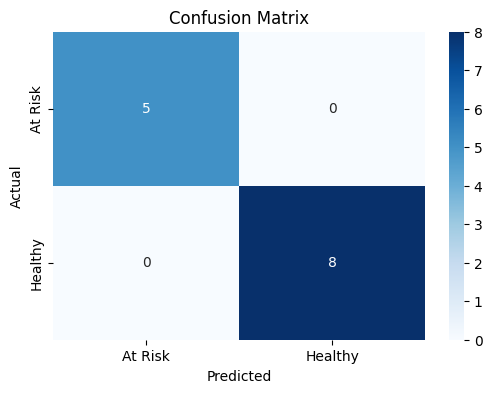

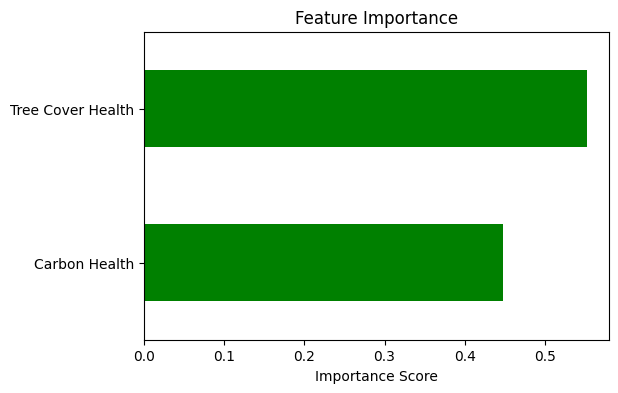

📁 Predictions saved to 'Forest_Health_Predictions.csv'


In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load the dataset ===
df = pd.read_csv(r"C:\Users\rsmvs\OneDrive\Desktop\Climate Project\Combined_Climate___Carbon_Health.csv")

# === 2. Create target label ===
df["Forest_Health_Status"] = df.apply(
    lambda row: "Healthy" if row["Carbon_Health_Status"] == "Improving" and row["Tree_Cover_Health_Status"] == "Improving"
    else "At Risk", axis=1
)

# === 3. Encode features ===
le_carbon = LabelEncoder()
le_tree = LabelEncoder()
le_target = LabelEncoder()

df["carbon_encoded"] = le_carbon.fit_transform(df["Carbon_Health_Status"])
df["tree_encoded"] = le_tree.fit_transform(df["Tree_Cover_Health_Status"])
df["target_encoded"] = le_target.fit_transform(df["Forest_Health_Status"])

# === 4. Define features and target ===
X = df[["carbon_encoded", "tree_encoded"]]
y = df["target_encoded"]

# === 5. Split data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 6. Train the model ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === 7. Evaluate the model ===
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("✅ Accuracy:", accuracy)
print("✅ F1 Score:", f1)
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))

# === 8. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === 9. Feature Importance ===
feat_importances = pd.Series(model.feature_importances_, index=["Carbon Health", "Tree Cover Health"])
plt.figure(figsize=(6, 4))
feat_importances.plot(kind='barh', color='green')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()

# === 10. Predict for full dataset and save ===
df["Predicted_Forest_Health"] = le_target.inverse_transform(model.predict(X))
df[["subnational1", "Carbon_Health_Status", "Tree_Cover_Health_Status", "Predicted_Forest_Health"]].to_csv("Forest_Health_Predictions.csv", index=False)
print("📁 Predictions saved to 'Forest_Health_Predictions.csv'")
